# Import Required Libraries

In [ ]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
# Import necessary libraries
import pandas as pd
from bertopic import BERTopic
from transformers import AutoTokenizer, pipeline
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

device = 0 if torch.cuda.is_available() else -1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Mounted at /content/drive


# Topic Modeling

In [ ]:
def apply_topic_modeling(df, text_column="content", nr_topics=40, topic_column="topic"):
    """
    Applies BERTopic modeling on a specified text column in a DataFrame.
    Allows specifying a different column name for topics to prevent overwriting.
    """

    df = df.dropna(subset=[text_column]).copy()
    docs = df[text_column].astype(str).tolist()

    # Apply BERTopic
    topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, nr_topics=nr_topics)
    topics, probs = topic_model.fit_transform(docs)

    # Store results in a custom column
    df[topic_column] = topics
    df[f"{topic_column}_info"] = df[topic_column].apply(
        lambda t: topic_model.topic_labels_[t] if t in topic_model.topic_labels_ else "Unknown"
    )

    # Get topic frequency
    topic_freq = topic_model.get_topic_info()

    return df, topic_freq, topic_model

# Sentiment Analysis

In [ ]:
def apply_sentiment_analysis(df, text_column="content", model_name="siebert/sentiment-roberta-large-english", output_file="sentiment_results.csv"):
    """Applies sentiment analysis on a DataFrame column and saves the results."""

    device = 0 if torch.cuda.is_available() else -1
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    sentiment_analysis = pipeline("sentiment-analysis", model=model_name, device=device)

    def process_text(text):
        if not isinstance(text, str) or text.strip() == "":
            return "NEUTRAL"

        tokens = tokenizer(text, truncation=True, max_length=512, return_tensors="pt")
        truncated_text = tokenizer.decode(tokens["input_ids"][0], skip_special_tokens=True)

        return sentiment_analysis(truncated_text)[0]['label']

    tqdm.pandas(desc="Processing Sentiment")
    df["sentiment"] = df[text_column].progress_apply(process_text)
    df.to_csv(output_file, index=False)

    return df, df["sentiment"].value_counts()

In [ ]:
def plot_sentiment_distribution(df, sentiment_column="sentiment", title="Sentiment Distribution", colors=["green", "red", "gray"]):
    """Plots the sentiment distribution as a bar chart."""

    sentiment_counts = df[sentiment_column].value_counts()
    sentiment_counts.plot(kind="bar", color=colors)
    plt.title(title)
    plt.xlabel("Sentiment")
    plt.ylabel("Review Count")
    plt.xticks(rotation=0)
    plt.show()

In [ ]:
def plot_sentiment_distribution_by_topic(df, topic_column="topic", sentiment_column="sentiment"):
    """Plots the sentiment distribution across topics using a sorted stacked bar chart and a heatmap."""

    # Count sentiment occurrences per topic
    sentiment_distribution = df.groupby([topic_column, sentiment_column]).size().unstack(fill_value=0)

    # Normalize to percentage
    sentiment_distribution_percent = sentiment_distribution.div(sentiment_distribution.sum(axis=1), axis=0) * 100

    # Sort topics by the highest percentage of negative sentiment
    if "NEGATIVE" in sentiment_distribution_percent.columns:
        sentiment_distribution_percent = sentiment_distribution_percent.sort_values(by="NEGATIVE", ascending=False)

    # Stacked bar chart (sorted by negativity)
    plt.figure(figsize=(12, 4))
    sentiment_distribution_percent.plot(kind="bar", stacked=True, colormap="viridis", figsize=(14,6))
    plt.title("Sentiment Distribution Across Topics (Sorted by Most Negative)")
    plt.xlabel("Topic")
    plt.ylabel("Percentage of Sentiment")
    plt.legend(title="Sentiment")
    plt.xticks(rotation=45)
    plt.show()

    # Heatmap (same sorting)
    plt.figure(figsize=(10, 8))
    sns.heatmap(sentiment_distribution_percent, cmap="coolwarm", annot=True, fmt=".1f")
    plt.title("Sentiment Heatmap by Topic (Sorted by Most Negative)")
    plt.xlabel("Sentiment")
    plt.ylabel("Topic")
    plt.show()


# Filter Topics Related to Ads

In [ ]:
def filter_ad_related_topics(df, topic_freq):
    """Filters reviews belonging to topics that contain advertising-related keywords in their 'Name' column."""

    ad_keywords = {"ads", "advertisement", "ad", "commercials", "add",
                   "fake", "misleading", "deceptive", "bait", "scam"}

    found_topics = []
    # Ensure "Name" is a string and split it into words
    for index, row in topic_freq.iterrows():
        name = str(row["Name"])  # Convert to string
        words = name.split("_")  # Split by underscore
        if any(k in words for k in ad_keywords):
            found_topics.append(row["Topic"])

    ad_topic_ids = set(found_topics)

    print(f"\nTopics containing ad-related keywords: {sorted(ad_topic_ids)}")
    filtered_df = df[df["topic"].isin(ad_topic_ids)].copy()

    return filtered_df

# puzzles_and_survival

In [ ]:
# Define file path in Google Drive
file_path = "/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Puzzles and survival.csv"

# Load the dataset
puzzles_and_survival = pd.read_csv(file_path)
puzzles_and_survival

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,8a33d8e3-1793-472d-89a9-5fbbe4a88707,Patrice Sidney,https://play-lh.googleusercontent.com/a-/ALV-U...,Puzzles & Survivors offers a uniquely challeng...,5,0,7.0.182,26/02/2025 09:26,NaN,NaN,7.0.182
1,018b768d-2dec-48e6-9595-9c64a5e41311,Breanne B,https://play-lh.googleusercontent.com/a-/ALV-U...,What even is this? I downloaded it thinking it...,2,0,7.0.182,26/02/2025 07:06,"Dear player, sorry for any unpleasant caused. ...",26/02/2025 09:02,7.0.182
2,26f5ff01-deed-45e2-9651-7a76311812a6,Joseph Hand,https://play-lh.googleusercontent.com/a-/ALV-U...,"It would be higher, but I'm tired of it crashi...",3,0,7.0.182,25/02/2025 14:03,"Dear player, sorry for any unpleasant caused. ...",26/02/2025 03:47,7.0.182
3,6a24adbe-baf1-4916-985d-7b36f1f751dc,Akari Windsor,https://play-lh.googleusercontent.com/a-/ALV-U...,Is it really that hard to make a game that mat...,1,0,7.0.182,25/02/2025 11:35,"Hi, dear player, we are sorry that our game do...",25/02/2025 11:56,7.0.182
4,6d88718e-6051-4943-9cff-25200030bcc5,Cory Cameron,https://play-lh.googleusercontent.com/a/ACg8oc...,love this game,5,0,7.0.182,25/02/2025 08:33,NaN,NaN,7.0.182
...,...,...,...,...,...,...,...,...,...,...,...
9995,022fc5a5-7573-4f16-bffb-5be4878453e8,Mohamed Ashraf,https://play-lh.googleusercontent.com/a-/ALV-U...,That's great 😸👍,5,0,NaN,15/04/2023 10:03,NaN,NaN,NaN
9996,99c79e44-36fd-48fb-9034-5b0cecdae983,Ryen Nixon,https://play-lh.googleusercontent.com/a/ACg8oc...,Fun and addictive,5,0,7.0.99,15/04/2023 08:59,NaN,NaN,7.0.99
9997,b99858a8-37b1-43c5-9362-e543cde2ba62,Karl Taylor,https://play-lh.googleusercontent.com/a-/ALV-U...,Not a fan. Clearly I'm not the demographic for...,1,32,7.0.52,15/04/2023 07:43,"Dear player,sorry for your unpleasant experien...",15/04/2023 10:32,7.0.52
9998,9dc9bc2c-cbde-4d87-9e2d-dcd1798c934a,Darian Gomez,https://play-lh.googleusercontent.com/a-/ALV-U...,I want Leon :(,4,0,7.0.99,15/04/2023 07:35,NaN,NaN,7.0.99


In [ ]:
puzzles_and_survival, topic_freq, topic_model = apply_topic_modeling(puzzles_and_survival, text_column="content", nr_topics=40, topic_column="topic")
topic_freq

2025-03-02 17:37:55,978 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2025-03-02 17:38:21,878 - BERTopic - Embedding - Completed ✓
2025-03-02 17:38:21,879 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-02 17:38:44,683 - BERTopic - Dimensionality - Completed ✓
2025-03-02 17:38:44,687 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-02 17:39:04,849 - BERTopic - Cluster - Completed ✓
2025-03-02 17:39:04,850 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-02 17:39:05,217 - BERTopic - Representation - Completed ✓
2025-03-02 17:39:05,221 - BERTopic - Topic reduction - Reducing number of topics
2025-03-02 17:39:05,563 - BERTopic - Topic reduction - Reduced number of topics from 209 to 40


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2217,-1_to_and_the_it,"[to, and, the, it, game, this, is, you, of, for]","[So far, it seems like a pretty fun game! I'm ..."
1,0,2871,0_game_to_great_fun,"[game, to, great, fun, you, good, this, and, p...","[Good game to play like it ✅👍, The game is gre..."
2,1,807,1_fun_entertaining_lots_enjoyable,"[fun, entertaining, lots, enjoyable, its, bori...","[Fun, Fun, Fun]"
3,2,734,2_awesome_good_cool_nice,"[awesome, good, cool, nice, great, excellent, ...","[Awesome, Awesome, Awesome]"
4,3,672,3_ads_the_ad_is,"[ads, the, ad, is, like, game, not, nothing, t...",[I like it but the ads are misleading it's not...
5,4,289,4_zombies_zombie_saw_resident,"[zombies, zombie, saw, resident, evil, and, su...","[Zombies, Zombies!, Fun and zombies.]"
6,5,272,5_love_it_its_ok,"[love, it, its, ok, alright, like, okay, good,...","[I love it 😀, Love it, Love it]"
7,6,267,6_far_so_good_bad,"[far, so, good, bad, pretty, decent, very, not...","[Good so far, Good so far, Good so far]"
8,7,230,7_advertised_false_ads_nothing,"[advertised, false, ads, nothing, advertising,...","[Nothing like advertised, Nothing like adverti..."
9,8,188,8_load_it_loading_keeps,"[load, it, loading, keeps, fix, the, and, game...",[I fell in love with this game fast. My only p...


In [ ]:
# Visualize topic distribution
topic_model.visualize_topics()

In [ ]:
# Show top 20 topics as a bar chart
topic_model.visualize_barchart(top_n_topics=20)

In [ ]:
# If sentiment analysis has not been performed yet, Uncomment the following line
# puzzles_and_survival, sentiment_counts = apply_sentiment_analysis(puzzles_and_survival, text_column="content", output_file="/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Sentiment Results/Puzzles_and_survival_sentiment.csv")

# Else, load the saved results from Google Drive
sentiment_df = pd.read_csv("/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Sentiment Results/Puzzles_and_survival_sentiment.csv")
puzzles_and_survival = puzzles_and_survival.merge(sentiment_df[["reviewId", "sentiment"]], on="reviewId", how="left")

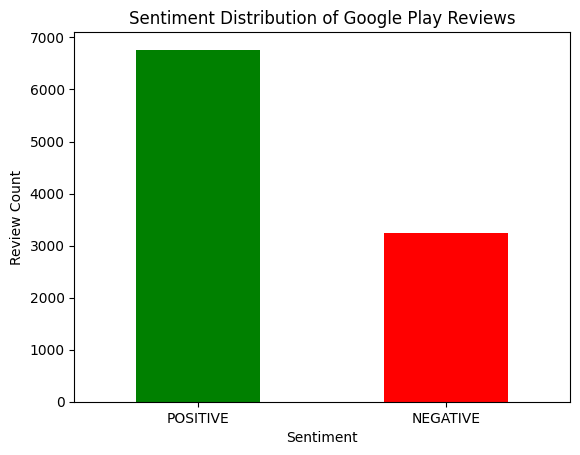

<Figure size 1200x400 with 0 Axes>

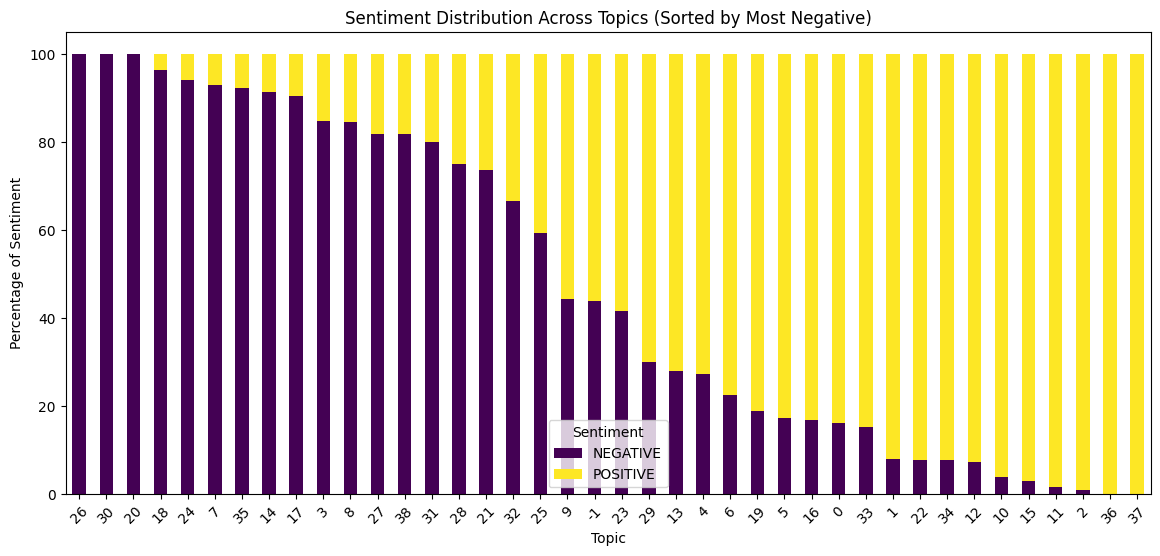

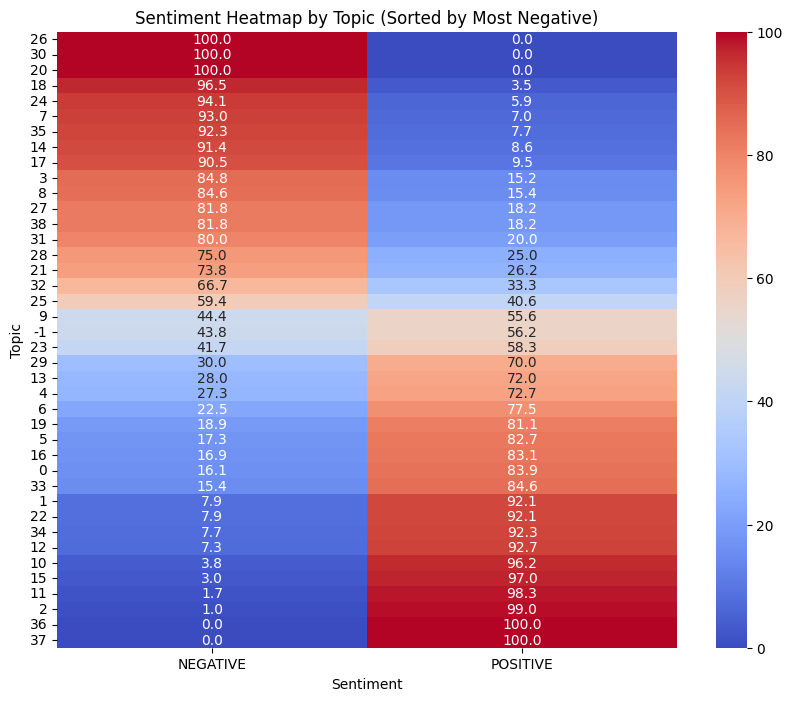

In [ ]:
plot_sentiment_distribution(puzzles_and_survival, sentiment_column="sentiment", title="Sentiment Distribution of Google Play Reviews")

plot_sentiment_distribution_by_topic(puzzles_and_survival, topic_column="topic", sentiment_column="sentiment")

# Secondary Topic Modeling on filtered ad-related reviews

In [ ]:
# Filter reviews that belong to ad-related topics
puzzles_and_survival_ad = filter_ad_related_topics(puzzles_and_survival, topic_freq)

# Apply Secondary Topic Modeling on filtered ad-related reviews (with a different topic column)
puzzles_and_survival_ad, ad_topic_freq, ad_topic_model = apply_topic_modeling(puzzles_and_survival_ad, text_column="content", topic_column="ad_topic")

# Save the new dataset with both the original and ad-related topics
puzzles_and_survival_ad.to_csv("/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Ads_Related/Puzzles_and_survival_ad_reviews.csv", index=False)
ad_topic_freq


2025-03-02 17:39:08,924 - BERTopic - Embedding - Transforming documents to embeddings.



Topics containing ad-related keywords: [3, 7, 21, 30]


Batches:   0%|          | 0/30 [00:00<?, ?it/s]

2025-03-02 17:39:12,327 - BERTopic - Embedding - Completed ✓
2025-03-02 17:39:12,329 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-02 17:39:14,658 - BERTopic - Dimensionality - Completed ✓
2025-03-02 17:39:14,659 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-02 17:39:14,727 - BERTopic - Cluster - Completed ✓
2025-03-02 17:39:14,728 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-02 17:39:14,763 - BERTopic - Representation - Completed ✓
2025-03-02 17:39:14,763 - BERTopic - Topic reduction - Reducing number of topics
2025-03-02 17:39:14,765 - BERTopic - Topic reduction - Reduced number of topics from 13 to 13


,Topic,Count,Name,Representation,Representative_Docs
0,0,36,0_as_advertised_not_booo,"[as, advertised, not, booo, corny, unoriginal,...","[Not as advertised, Not as advertised, Not as ..."
1,1,18,1_advertised_what_not_was,"[advertised, what, not, was, whats, its, def, ...","[Not what was advertised, Not what was adverti..."
2,2,16,2_advertised_nothing_like_rest,"[advertised, nothing, like, rest, bother, was,...","[Nothing like advertised, Nothing like adverti..."
3,3,16,3_scam_cheating_will_lying,"[scam, cheating, will, lying, pay, aholes, scu...","[Scam, Scam, Scam]"
4,4,40,4_add_adds_the_like,"[add, adds, the, like, game, play, not, to, it...","[Nothing like the add, Nothing like the add, N..."
5,5,78,5_like_nothing_ad_ads,"[like, nothing, ad, ads, the, not, from, diffe...","[Nothing like the ads!, Nothing like the ads, ..."
6,6,61,6_advertised_not_game_as,"[advertised, not, game, as, the, same, is, tha...","[Not the advertised game, Not the game adverti..."
7,7,41,7_false_advertising_advertisement_ad,"[false, advertising, advertisement, ad, advert...","[False advertising, False advertising, False a..."
8,8,41,8_misleading_ads_fake_are,"[misleading, ads, fake, are, deceptive, ad, li...","[Misleading ads., Misleading ads, Misleading ads]"
9,9,64,9_women_the_men_is,"[women, the, men, is, are, this, and, for, to,...",[The women in this game are absurdly sexualize...


# Same analysis for the rest of the games

In [ ]:
# Define file path in Google Drive
file_path = "/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Hustle Castle.csv"

# Load the dataset
hustle_castle = pd.read_csv(file_path)
hustle_castle

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,7fd734eb-a406-4412-ba99-9151b4faf32a,Dragonessi,https://play-lh.googleusercontent.com/a-/ALV-U...,Game's good 💯💯💯 5-6 years 🥲🥲🥲,5,0,NaN,2025-02-26 14:32:39,We appreciate your enthusiasm and long-term su...,2025-02-11 10:31:16,NaN
1,2ca0b344-d7f4-47fe-b98d-b628e1a307a3,Shawn Thornton,https://play-lh.googleusercontent.com/a/ACg8oc...,Love the game,5,0,1.114.1,2025-02-25 01:39:53,We appreciate your support and are glad you lo...,2025-02-25 09:33:53,1.114.1
2,abbf7b96-0085-462a-88fa-b7c20cf5a380,Christopher Caddock,https://play-lh.googleusercontent.com/a/ACg8oc...,This game is not worth your money,1,0,1.6.0,2025-02-24 19:43:49,Thank you for your feedback! We always appreci...,2025-02-25 09:37:58,1.6.0
3,7e22aa25-c334-4634-9b9b-4115ded2627f,JB Jackson,https://play-lh.googleusercontent.com/a-/ALV-U...,Like it,4,0,1.114.1,2025-02-24 09:38:53,We appreciate your positive feedback and are g...,2025-02-24 11:53:25,1.114.1
4,c732ec6d-4e10-46fa-bcba-b04f0570c45f,Jaia,https://play-lh.googleusercontent.com/a/ACg8oc...,Another game that could have been good if they...,1,0,1.114.1,2025-02-22 23:01:08,Thank you for your feedback! We always appreci...,2025-02-24 11:59:27,1.114.1
...,...,...,...,...,...,...,...,...,...,...,...
9995,283e77d0-56d1-4264-bb4b-9db05a579792,Jeff,https://play-lh.googleusercontent.com/a/ACg8oc...,Pay to play at it's worst,1,0,1.24.1,2020-06-02 17:37:28,NaN,NaN,1.24.1
9996,c494ddbd-efa7-47aa-8689-f0780b25fe5e,arvind jamod,https://play-lh.googleusercontent.com/a-/ALV-U...,Good,5,0,1.24.1,2020-06-02 16:25:30,NaN,NaN,1.24.1
9997,371edba8-2750-4947-8592-da5c7bd0736c,Luka,https://play-lh.googleusercontent.com/a/ACg8oc...,Copied fallout shelter,1,0,NaN,2020-06-02 16:14:01,NaN,NaN,NaN
9998,ad207ded-b388-4bda-8ac5-219efe473fd5,queso dip,https://play-lh.googleusercontent.com/a/ACg8oc...,Game is a joke. Come selling your kidney and l...,1,2,1.24.1,2020-06-02 13:29:09,NaN,NaN,1.24.1


In [ ]:
hustle_castle, topic_freq, topic_model = apply_topic_modeling(hustle_castle, text_column="content", nr_topics=40, topic_column="topic")
topic_freq

2025-03-02 17:40:25,634 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2025-03-02 17:40:34,648 - BERTopic - Embedding - Completed ✓
2025-03-02 17:40:34,649 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-02 17:40:54,378 - BERTopic - Dimensionality - Completed ✓
2025-03-02 17:40:54,380 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-02 17:41:09,962 - BERTopic - Cluster - Completed ✓
2025-03-02 17:41:09,963 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-02 17:41:10,275 - BERTopic - Representation - Completed ✓
2025-03-02 17:41:10,277 - BERTopic - Topic reduction - Reducing number of topics
2025-03-02 17:41:10,524 - BERTopic - Topic reduction - Reduced number of topics from 187 to 40


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2974,-1_to_the_game_and,"[to, the, game, and, it, you, is, this, of, for]","[fun, addicting game. I have been playing for ..."
1,0,1387,0_game_good_great_best,"[game, good, great, best, nice, fun, love, eve...","[This is a great and fun game to play., This i..."
2,1,943,1_to_you_the_and,"[to, you, the, and, is, arena, in, for, of, are]",[Hustle Castle is a fun and interesting game b...
3,2,655,2_good_nice_awesome_cool,"[good, nice, awesome, cool, great, excellent, ...","[Good, Good, Good]"
4,3,560,3_ads_ad_fake_nothing,"[ads, ad, fake, nothing, false, the, advertisi...","[Nothing like the ads, Not like the ads, Not l..."
5,4,478,4_update_loading_it_load,"[update, loading, it, load, the, game, cant, d...",[I tried playing the game and it wont let me p...
6,5,420,5_my_account_and_lost,"[my, account, and, lost, support, was, to, the...",[I was playing this game happily until it just...
7,6,329,6_fun_far_so_its,"[fun, far, so, its, entertaining, pretty, very...","[Fun, Fun., Fun]"
8,7,259,7_love_it_its_good,"[love, it, its, good, cool, like, ok, bye, am,...","[Love it, Love it, I Love it]"
9,8,187,8_meh_oyun_gud_hogy,"[meh, oyun, gud, hogy, gzel, yup, ne, gooood, ...","[meh, Meh., 1, A reklám egy nagy átverés, semm..."


In [ ]:
# Visualize topic distribution
topic_model.visualize_topics()

In [ ]:
# Show top 20 topics as a bar chart
topic_model.visualize_barchart(top_n_topics=20)

In [ ]:
# If sentiment analysis has not been performed yet, Uncomment the following line
# hustle_castle, sentiment_counts = apply_sentiment_analysis(hustle_castle, text_column="content", output_file="/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Sentiment Results/hustle_castle_sentiment.csv")

# Else, load the saved results from Google Drive
sentiment_df = pd.read_csv("/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Sentiment Results/hustle_castle_sentiment.csv")
hustle_castle = hustle_castle.merge(sentiment_df[["reviewId", "sentiment"]], on="reviewId", how="left")

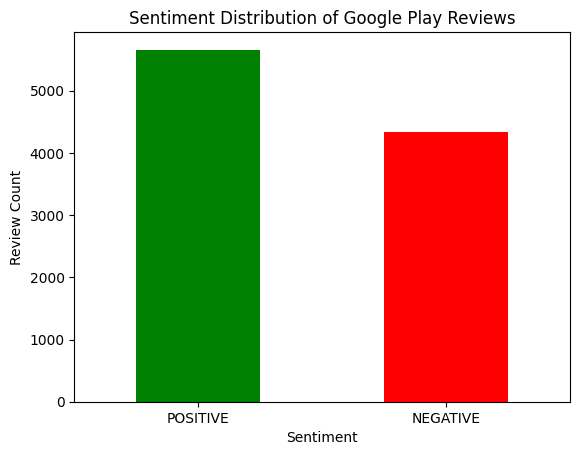

<Figure size 1200x400 with 0 Axes>

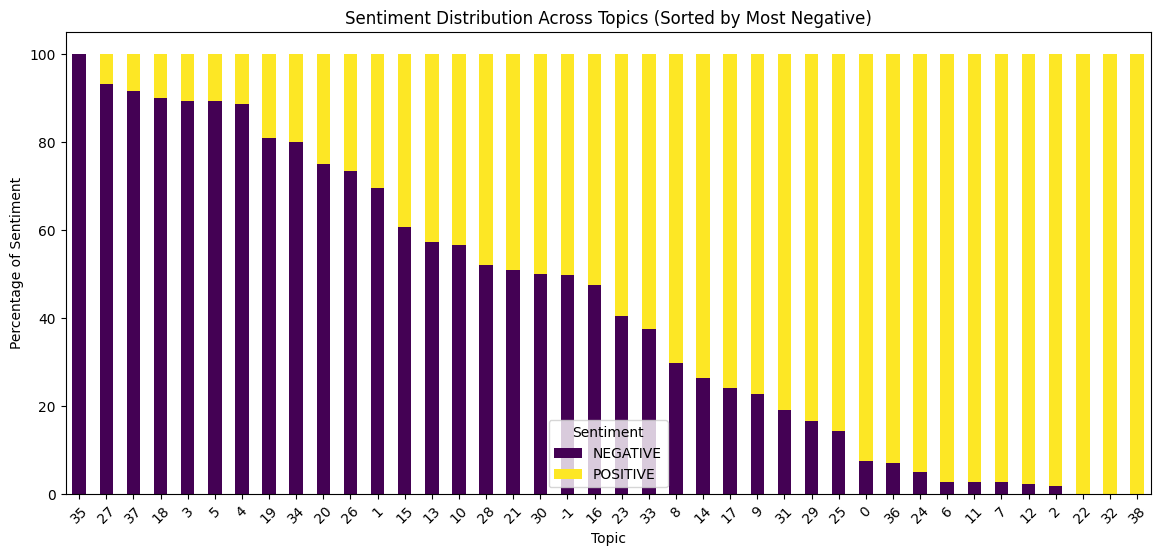

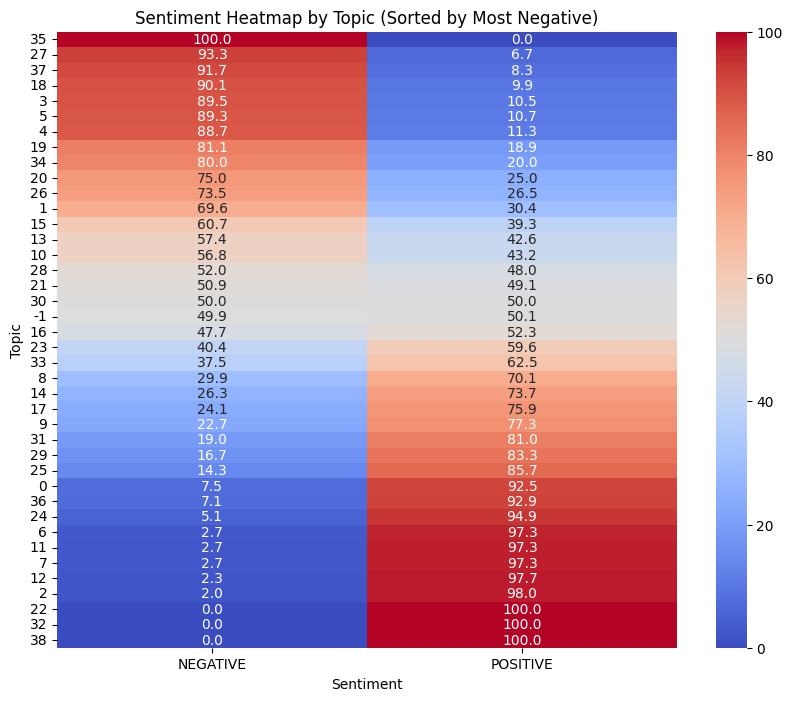

In [ ]:
plot_sentiment_distribution(hustle_castle, sentiment_column="sentiment", title="Sentiment Distribution of Google Play Reviews")

plot_sentiment_distribution_by_topic(hustle_castle, topic_column="topic", sentiment_column="sentiment")

In [ ]:
# Filter reviews that belong to ad-related topics
hustle_castle_ad = filter_ad_related_topics(hustle_castle, topic_freq)

# Apply Secondary Topic Modeling on filtered ad-related reviews (with a different topic column)
hustle_castle_ad, ad_topic_freq, ad_topic_model = apply_topic_modeling(hustle_castle_ad, text_column="content", topic_column="ad_topic")

# Save the new dataset with both the original and ad-related topics
hustle_castle_ad.to_csv("/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Ads_Related/hustle_castle_ad_reviews.csv", index=False)
ad_topic_freq

2025-03-02 17:41:13,632 - BERTopic - Embedding - Transforming documents to embeddings.



Topics containing ad-related keywords: [3, 20]


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

2025-03-02 17:41:16,425 - BERTopic - Embedding - Completed ✓
2025-03-02 17:41:16,426 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-02 17:41:17,651 - BERTopic - Dimensionality - Completed ✓
2025-03-02 17:41:17,652 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-02 17:41:17,697 - BERTopic - Cluster - Completed ✓
2025-03-02 17:41:17,697 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-02 17:41:17,726 - BERTopic - Representation - Completed ✓
2025-03-02 17:41:17,726 - BERTopic - Topic reduction - Reducing number of topics
2025-03-02 17:41:17,728 - BERTopic - Topic reduction - Reduced number of topics from 14 to 14


,Topic,Count,Name,Representation,Representative_Docs
0,0,60,0_adds_add_the_not,"[adds, add, the, not, game, to, is, its, but, ...",[Ok you want me to explain my one star ratting...
1,1,42,1_puzzle_puzzles_game_the,"[puzzle, puzzles, game, the, is, and, of, but,...",[I hate games that falsely adversatise game pl...
2,2,35,2_advertising_false_fake_lie,"[advertising, false, fake, lie, can, you, inte...","[False advertising, False advertising., False ..."
3,3,81,3_like_nothing_the_not,"[like, nothing, the, not, ads, advertised, wha...","[NOTHING LIKE THE ADS, Nothing like the ads, N..."
4,4,39,4_fake_ads_not_review,"[fake, ads, not, review, are, man, her, respon...","[Fake ads, Fake ads, Fake ads]"
5,5,20,5_advertised_not_game_was,"[advertised, not, game, was, as, same, that, i...","[Game not as advertised, Not the game that was..."
6,6,13,6_false_advertisement_lied_crime,"[false, advertisement, lied, crime, trouble, a...","[False advertisement, False advertisement, Fal..."
7,7,27,7_misleading_ads_clickbait_ad,"[misleading, ads, clickbait, ad, lieing, your,...","[Misleading ads, Misleading ads, Misleading ads]"
8,8,23,8_uninstalled_the_after_uninstall,"[uninstalled, the, after, uninstall, that, ads...",[I immediately uninstalled after I saw that it...
9,9,71,9_app_to_this_it,"[app, to, this, it, your, ad, the, and, exit, ...","[I haven't played this and don't want to, but ..."


In [ ]:
# Define file path in Google Drive
file_path = "/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Project makeover.csv"

# Load the dataset
project_makeover = pd.read_csv(file_path)
project_makeover

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,d8f73ce0-bfee-4f30-bafa-7e93ea5defbd,Kristine Clark,https://play-lh.googleusercontent.com/a/ACg8oc...,Awesome game,5,0,NaN,2025-02-26 09:57:36,NaN,NaN,NaN
1,0037df11-a655-441e-81e6-3e60b0ec5954,Ricky Ritchey,https://play-lh.googleusercontent.com/a/ACg8oc...,Love it,5,0,NaN,2025-02-26 07:50:48,NaN,NaN,NaN
2,be468a2b-a77c-405b-92d1-b36cb7dbed2a,Galaxy Kitten,https://play-lh.googleusercontent.com/a-/ALV-U...,It a really good game to play in your free tim...,5,0,2.108.1,2025-02-26 07:27:23,NaN,NaN,2.108.1
3,597a135d-3516-4d13-a3c2-6ecf208bf079,Gay Marie Camahalan,https://play-lh.googleusercontent.com/a-/ALV-U...,❤️❤️,5,0,2.108.1,2025-02-26 06:53:42,NaN,NaN,2.108.1
4,3905f438-4052-4f52-97ce-f8bb4d697d07,Linda Schaeffer,https://play-lh.googleusercontent.com/a/ACg8oc...,So far I love it,5,0,2.108.1,2025-02-26 05:05:36,NaN,NaN,2.108.1
...,...,...,...,...,...,...,...,...,...,...,...
9995,a6be5136-73ff-4c15-847e-c9b413cdc18d,Barbara Hanna,https://play-lh.googleusercontent.com/a/ACg8oc...,Beautiful,5,0,2.86.1,2024-04-15 16:51:23,NaN,NaN,2.86.1
9996,1221979f-59b7-4466-b522-b98c5c125bfc,sanchita Patkar,https://play-lh.googleusercontent.com/a-/ALV-U...,Not good Edit :- issue is as per your adds the...,1,0,2.86.1,2024-04-15 16:49:39,Thank you for your feedback. Could you please ...,2022-11-24 09:43:06,2.86.1
9997,d0567337-a929-480b-9f42-d9ba98361b1f,Tag Fay,https://play-lh.googleusercontent.com/a-/ALV-U...,Disgusting ad,1,1,NaN,2024-04-15 16:21:00,NaN,NaN,NaN
9998,10ae34d8-578c-4fe0-bc82-318e55a6229c,Yaya,https://play-lh.googleusercontent.com/a-/ALV-U...,Very creative 👌,5,0,2.86.1,2024-04-15 16:13:46,NaN,NaN,2.86.1


In [ ]:
project_makeover, topic_freq, topic_model = apply_topic_modeling(project_makeover, text_column="content", nr_topics=35, topic_column="topic")
topic_freq

2025-03-02 17:44:04,648 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2025-03-02 17:44:12,981 - BERTopic - Embedding - Completed ✓
2025-03-02 17:44:12,983 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-02 17:44:35,951 - BERTopic - Dimensionality - Completed ✓
2025-03-02 17:44:35,954 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-02 17:44:57,693 - BERTopic - Cluster - Completed ✓
2025-03-02 17:44:57,694 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-02 17:44:57,966 - BERTopic - Representation - Completed ✓
2025-03-02 17:44:57,967 - BERTopic - Topic reduction - Reducing number of topics
2025-03-02 17:44:58,180 - BERTopic - Topic reduction - Reduced number of topics from 208 to 35


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2388,-1_to_the_and_game,"[to, the, and, game, it, you, this, is, of, but]",[It's an okay game. The good thing about it is...
1,0,2301,0_game_this_love_nice,"[game, this, love, nice, fun, very, good, grea...",[This game is very fun . I like this game so m...
2,1,1046,1_good_nice_amazing_awesome,"[good, nice, amazing, awesome, excellent, grea...","[good, Nice and good 👍, Good, nice, game👌👍❤️🥰]"
3,2,560,2_fun_entertaining_so_its,"[fun, entertaining, so, its, enjoying, enjoyab...","[Fun, Fun, Fun]"
4,3,533,3_app_my_the_phone,"[app, my, the, phone, to, update, it, but, and...","[I love this app, but I got over level 900 and..."
5,4,493,4_to_you_the_gems,"[to, you, the, gems, coins, money, and, but, f...",[You have to constantly pay out if you want to...
6,5,345,5_ads_ad_no_the,"[ads, ad, no, the, to, moves, and, game, extra...","[Good game and no ads, Fun and no ads, It's fu..."
7,6,342,6_love_it_like_loving,"[love, it, like, loving, this, much, good, jus...","[Love it!, Love it 😀, Love it]"
8,7,320,7_makeover_project_makeovers_fashion,"[makeover, project, makeovers, fashion, the, a...","[ProJect Makeover is the best, i love you proj..."
9,8,254,8_mwah_good_so_amazing,"[mwah, good, so, amazing, wow, yse, kha, fany,...","[So good🤗, So 👍 good, So good✨]"


In [ ]:
# Visualize topic distribution
topic_model.visualize_topics()

In [ ]:
# Show top 20 topics as a bar chart
topic_model.visualize_barchart(top_n_topics=20)

In [ ]:
# If sentiment analysis has not been performed yet, Uncomment the following line
# project_makeover, sentiment_counts = apply_sentiment_analysis(project_makeover, text_column="content", output_file="/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Sentiment Results/project_makeover_sentiment.csv")

# Else, load the saved results from Google Drive
sentiment_df = pd.read_csv("/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Sentiment Results/project_makeover_sentiment.csv")
project_makeover = project_makeover.merge(sentiment_df[["reviewId", "sentiment"]], on="reviewId", how="left")

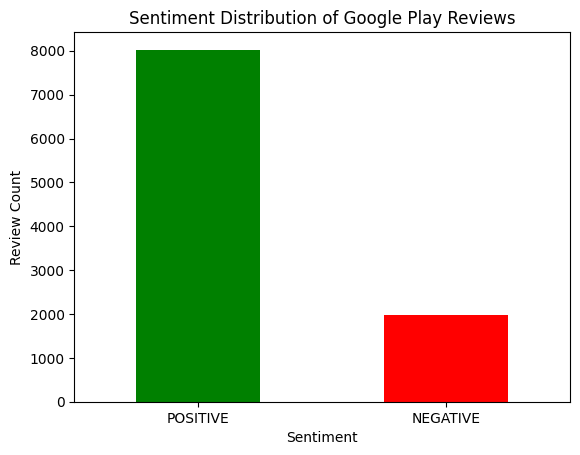

<Figure size 1200x400 with 0 Axes>

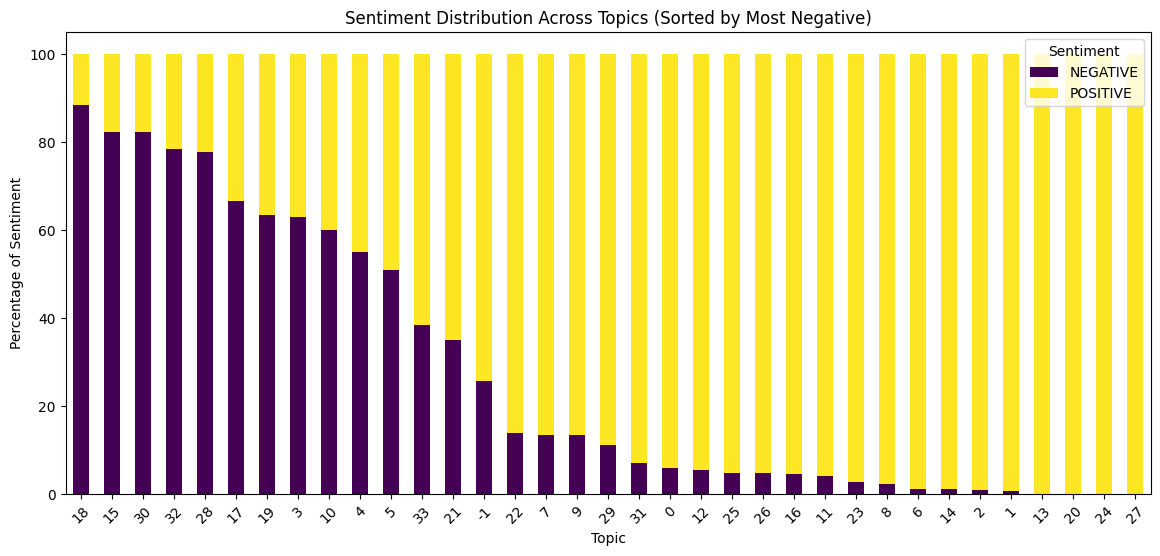

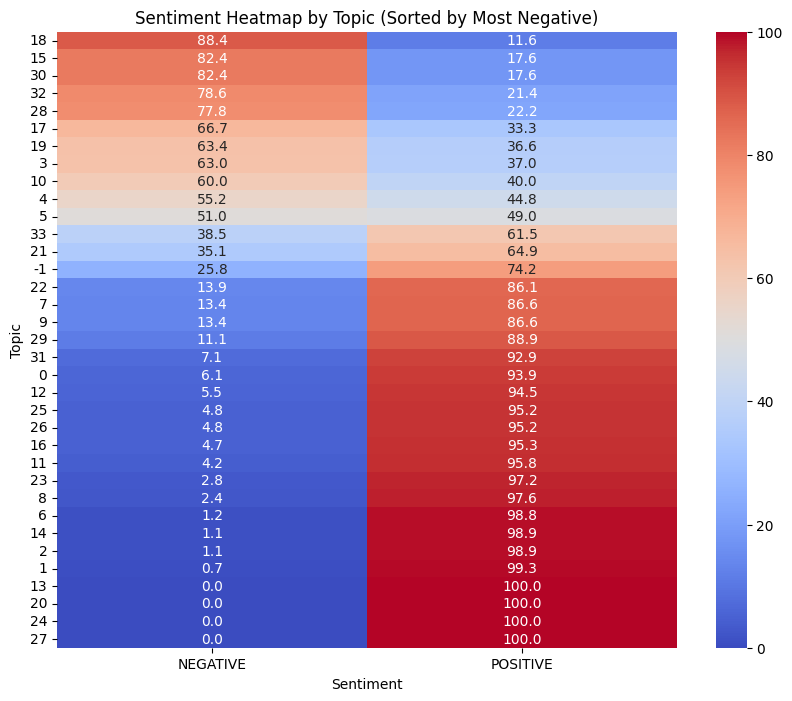

In [ ]:
plot_sentiment_distribution(project_makeover, sentiment_column="sentiment", title="Sentiment Distribution of Google Play Reviews")

plot_sentiment_distribution_by_topic(project_makeover, topic_column="topic", sentiment_column="sentiment")

In [ ]:
# Filter reviews that belong to ad-related topics
project_makeover_ad = filter_ad_related_topics(project_makeover, topic_freq)

# Apply Secondary Topic Modeling on filtered ad-related reviews (with a different topic column)
project_makeover_ad, ad_topic_freq, ad_topic_model = apply_topic_modeling(project_makeover_ad, text_column="content", topic_column="ad_topic")

# Save the new dataset with both the original and ad-related topics
project_makeover_ad.to_csv("/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Ads_Related/project_makeover_ad_reviews.csv", index=False)
ad_topic_freq

2025-03-02 17:45:19,056 - BERTopic - Embedding - Transforming documents to embeddings.



Topics containing ad-related keywords: [5, 15]


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

2025-03-02 17:45:21,773 - BERTopic - Embedding - Completed ✓
2025-03-02 17:45:21,775 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-02 17:45:22,522 - BERTopic - Dimensionality - Completed ✓
2025-03-02 17:45:22,523 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-02 17:45:22,550 - BERTopic - Cluster - Completed ✓
2025-03-02 17:45:22,550 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-02 17:45:22,576 - BERTopic - Representation - Completed ✓
2025-03-02 17:45:22,576 - BERTopic - Topic reduction - Reducing number of topics
2025-03-02 17:45:22,578 - BERTopic - Topic reduction - Reduced number of topics from 11 to 11


,Topic,Count,Name,Representation,Representative_Docs
0,-1,16,-1_game_the_this_is,"[game, the, this, is, ads, and, its, to, good,...",[I used to have this game until I came across ...
1,0,18,0_avatar_female_the_and,"[avatar, female, the, and, for, options, male,...",[I'd like to be able to give this more than 3 ...
2,1,50,1_women_the_and_this,"[women, the, and, this, woman, to, her, you, g...",[Appalling ads full of abuse! You're trying to...
3,2,93,2_to_the_and_moves,"[to, the, and, moves, you, get, extra, ads, it...",[There used to be an option to watch two ads t...
4,3,42,3_fun_no_ads_its,"[fun, no, ads, its, and, very, adverts, but, n...","[Fun and no ads, Fun! No ads!!, fun. no ads.]"
5,4,16,4_advertisement_advertising_false_fake,"[advertisement, advertising, false, fake, ads,...","[False advertisement, False advertisement..., ..."
6,5,22,5_too_many_ads_much,"[too, many, ads, much, annoying, long, lots, c...","[Too many ads, Too many ads, Too many ads]"
7,6,15,6_like_nothing_the_ads,"[like, nothing, the, ads, not, same, ad, its, ...","[Nothing like the ad..., Nothing like the ads...."
8,7,44,7_game_the_is_it,"[game, the, is, it, like, ads, not, this, adve...",[It's a good game but nothing like the ads for...
9,8,15,8_no_game_ads_with,"[no, game, ads, with, fun, very, good, play, g...","[A very good game with no ads, Fun game with n..."


In [ ]:
# Define file path in Google Drive
file_path = "/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Hero wars.csv"

# Load the dataset
hero_wars = pd.read_csv(file_path)
hero_wars

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,f4d7f4ad-dae6-44df-8a6c-dd485c8d656c,Aadhila Salahudeen,https://play-lh.googleusercontent.com/a-/ALV-U...,Very Bad,5,0,NaN,2025-02-26 12:34:09,NaN,NaN,NaN
1,f1bda9da-3437-4e90-b4a9-3d8bfc1a3914,CEO “Ceo” ARU,https://play-lh.googleusercontent.com/a-/ALV-U...,this game is amazing. i had a lot of fun,5,0,1.233.002,2025-02-26 10:11:38,NaN,NaN,1.233.002
2,a7a06d68-81ea-47d9-95c4-473d4e72a8a2,masraful,https://play-lh.googleusercontent.com/a-/ALV-U...,Not good.,1,0,NaN,2025-02-26 08:43:08,NaN,NaN,NaN
3,5f5155a7-b1bd-4aef-ad7a-4bcc302fcaf5,Sanghamitra Pal,https://play-lh.googleusercontent.com/a-/ALV-U...,Game and ad both are totally different,1,0,1.235.001,2025-02-26 07:25:49,NaN,NaN,1.235.001
4,e0fe1f1f-cb65-4de7-895d-c61a1ee1fc4d,Paulina Gajda-Esteves,https://play-lh.googleusercontent.com/a/ACg8oc...,lot's of fun,5,0,1.232.000,2025-02-26 05:14:40,NaN,NaN,1.232.000
...,...,...,...,...,...,...,...,...,...,...,...
9995,9ca5b703-ab03-4ba6-baaf-1248fa2548f7,Marjorie Nacorda,https://play-lh.googleusercontent.com/a/ACg8oc...,very nice,5,0,1.193.002,2024-03-07 18:08:48,"Hello! Thanks for your feedback, it helps us m...",2024-03-09 23:56:20,1.193.002
9996,76701b9a-27b6-4743-a34e-59c9aa706e49,KarmaKonquers,https://play-lh.googleusercontent.com/a-/ALV-U...,"Your ads are LIES, the game is nothing like th...",1,0,1.193.002,2024-03-07 16:53:07,Thank you for your feedback! We have taken som...,2024-03-09 23:56:55,1.193.002
9997,755b8e10-1459-43ba-8507-439692503e8c,Emiljano Zoi,https://play-lh.googleusercontent.com/a-/ALV-U...,nice game,5,0,1.193.002,2024-03-07 16:44:52,"Hello! Thanks for your feedback, it helps us m...",2024-03-09 23:56:24,1.193.002
9998,1029885a-52fe-4ed5-bea9-6fcf761ed9af,Tybowlie,https://play-lh.googleusercontent.com/a-/ALV-U...,Love this game keeps me distracted,5,0,1.193.002,2024-03-07 16:13:27,Hello! Thank you very much for the detailed fe...,2024-03-09 23:55:24,1.193.002


In [ ]:
hero_wars, topic_freq, topic_model = apply_topic_modeling(hero_wars, text_column="content", nr_topics=45, topic_column="topic")
topic_freq

2025-03-02 17:48:34,771 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2025-03-02 17:48:41,627 - BERTopic - Embedding - Completed ✓
2025-03-02 17:48:41,628 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-02 17:49:04,508 - BERTopic - Dimensionality - Completed ✓
2025-03-02 17:49:04,510 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-02 17:49:18,051 - BERTopic - Cluster - Completed ✓
2025-03-02 17:49:18,052 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-02 17:49:18,337 - BERTopic - Representation - Completed ✓
2025-03-02 17:49:18,338 - BERTopic - Topic reduction - Reducing number of topics
2025-03-02 17:49:18,559 - BERTopic - Topic reduction - Reduced number of topics from 185 to 45


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2444,-1_the_and_to_is,"[the, and, to, is, game, this, it, you, ads, of]",[I thought you get to fight up the castle like...
1,0,1889,0_game_nice_good_great,"[game, nice, good, great, fun, love, very, thi...","[nice fun game, nice and fun game, Very nice g..."
2,1,765,1_nice_good_great_excellent,"[nice, good, great, excellent, amazing, thank,...","[Nice, nice, nice and good]"
3,2,714,2_ads_the_like_ad,"[ads, the, like, ad, false, nothing, is, not, ...","[Not like the ads., Game is nothing like the a..."
4,3,394,3_data_personal_parties_third,"[data, personal, parties, third, to, agree, yo...","[To play the game, you literally have to agree..."
5,4,378,4_fun_entertaining_lots_challenging,"[fun, entertaining, lots, challenging, its, si...","[fun!, Fun!, fun]"
6,5,317,5_money_to_pay_you,"[money, to, pay, you, spend, have, and, but, g...",[Where to start... they don't pay out on the o...
7,6,316,6_hai_bhai_maganda_iklan,"[hai, bhai, maganda, iklan, pangit, na, ang, b...",[ang ganda nang advertise ang pangit nang laro...
8,7,273,7_hero_to_the_and,"[hero, to, the, and, heroes, new, heros, you, ...",[One star for last game changes.. The game is ...
9,8,266,8_crashes_loading_load_it,"[crashes, loading, load, it, connection, game,...","[I really like thik game , though it is not li..."


In [ ]:
# Visualize topic distribution
topic_model.visualize_topics()

In [ ]:
# Show top 20 topics as a bar chart
topic_model.visualize_barchart(top_n_topics=20)

In [ ]:
# If sentiment analysis has not been performed yet, Uncomment the following line
# hero_wars, sentiment_counts = apply_sentiment_analysis(hero_wars, text_column="content", output_file="/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Sentiment Results/hero_wars_sentiment.csv")

# Else, load the saved results from Google Drive
sentiment_df = pd.read_csv("/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Sentiment Results/hero_wars_sentiment.csv")
hero_wars = hero_wars.merge(sentiment_df[["reviewId", "sentiment"]], on="reviewId", how="left")

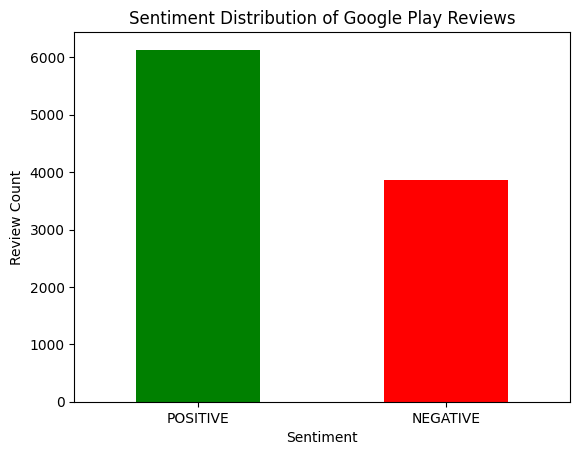

<Figure size 1200x400 with 0 Axes>

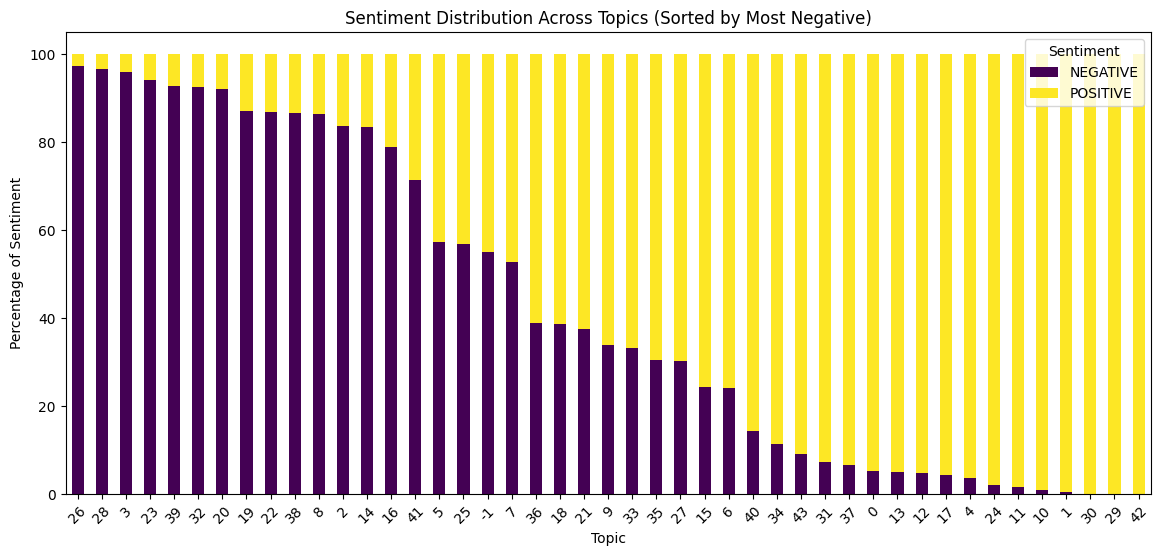

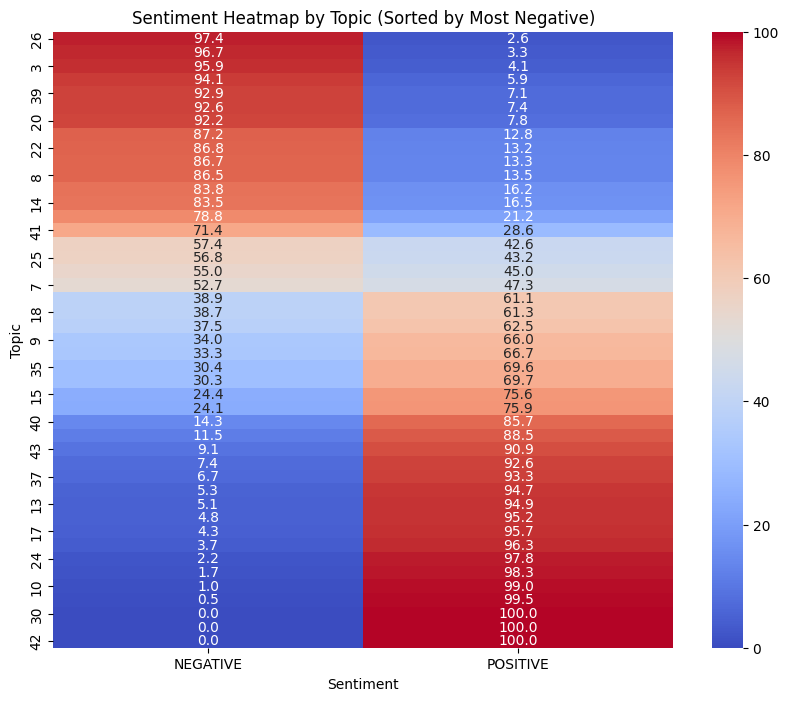

In [ ]:
plot_sentiment_distribution(hero_wars, sentiment_column="sentiment", title="Sentiment Distribution of Google Play Reviews")

plot_sentiment_distribution_by_topic(hero_wars, topic_column="topic", sentiment_column="sentiment")

In [ ]:
# Filter reviews that belong to ad-related topics
hero_wars_ad = filter_ad_related_topics(hero_wars, topic_freq)

# Apply Secondary Topic Modeling on filtered ad-related reviews (with a different topic column)
hero_wars_ad, ad_topic_freq, ad_topic_model = apply_topic_modeling(hero_wars_ad, text_column="content", topic_column="ad_topic", nr_topics=10)

# Save the new dataset with both the original and ad-related topics
hero_wars_ad.to_csv("/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Ads_Related/hero_wars_ad_reviews.csv", index=False)
ad_topic_freq

2025-03-02 17:50:49,474 - BERTopic - Embedding - Transforming documents to embeddings.



Topics containing ad-related keywords: [2, 16, 28, 39]


Batches:   0%|          | 0/27 [00:00<?, ?it/s]

2025-03-02 17:50:52,399 - BERTopic - Embedding - Completed ✓
2025-03-02 17:50:52,400 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-02 17:50:54,378 - BERTopic - Dimensionality - Completed ✓
2025-03-02 17:50:54,379 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-02 17:50:54,449 - BERTopic - Cluster - Completed ✓
2025-03-02 17:50:54,450 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-02 17:50:54,490 - BERTopic - Representation - Completed ✓
2025-03-02 17:50:54,490 - BERTopic - Topic reduction - Reducing number of topics
2025-03-02 17:50:54,523 - BERTopic - Topic reduction - Reduced number of topics from 21 to 10


,Topic,Count,Name,Representation,Representative_Docs
0,-1,36,-1_ads_the_watch_game,"[ads, the, watch, game, to, ad, you, in, like,...","[It's not the game in the ads., I literally ju..."
1,0,320,0_the_game_ads_is,"[the, game, ads, is, to, and, it, like, of, you]","[Game is nothing like the ads, False advertisi..."
2,1,136,1_false_advertising_fake_misleading,"[false, advertising, fake, misleading, ads, ad...","[False advertising, False advertising, False a..."
3,2,102,2_adds_add_the_game,"[adds, add, the, game, like, is, its, not, to,...","[It is nothing like the add, Not like the adds..."
4,3,87,3_star_to_game_the,"[star, to, game, the, stars, this, it, for, of...",[I don't play your game but need to watch an a...
5,4,81,4_ads_like_nothing_the,"[ads, like, nothing, the, not, annoying, too, ...","[Nothing like the ads, Nothing like the ads., ..."
6,5,39,5_what_not_in_ad,"[what, not, in, ad, the, different, same, from...",[It's very different from what was shown in th...
7,6,30,6_scam_game_and_the,"[scam, game, and, the, to, you, this, play, ga...",[This is another cheat cash grab game. It used...
8,7,17,7_scam_hoes_print_suspicious,"[scam, hoes, print, suspicious, fraud, fine, s...","[Scam, Scam, Scam]"
9,8,14,8_fake_legit_100_super,"[fake, legit, 100, super, totally, real, show,...","[Fake, Fake, Fake.]"


In [ ]:
# Define file path in Google Drive
file_path = "/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Last fortress.csv"

# Load the dataset
last_fortress = pd.read_csv(file_path)
last_fortress

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,75fa322b-4bc4-430d-9ab1-82a9da928c85,Jamichael Williamson,https://play-lh.googleusercontent.com/a-/ALV-U...,It's a good strategy game,5,0,25.0204.001,2025-02-26 14:41:57,"Dear player, thank you so much for your suppor...",2025-02-27 01:40:10,25.0204.001
1,46d375ea-85b0-4804-8d38-fe6460aed8bb,Roshan Bedia,https://play-lh.googleusercontent.com/a-/ALV-U...,Roshan❤❤❤❤,5,0,NaN,2025-02-26 11:51:18,"Dear player, thank you so much for your suppor...",2025-02-27 01:40:11,NaN
2,eb96b9e5-784d-4084-aae3-a72bb6ab24d1,Tailfinder WarHawks,https://play-lh.googleusercontent.com/a-/ALV-U...,Good game,4,0,25.0204.001,2025-02-26 11:47:27,"Dear player, thank you so much for your suppor...",2025-02-27 01:40:11,25.0204.001
3,3817745e-0189-48c0-8689-8087bc10d974,QU33NI3 BL45T,https://play-lh.googleusercontent.com/a-/ALV-U...,Unplayable. I can't even get pass the loading ...,1,0,NaN,2025-02-26 09:44:44,"Dear player, we apologize for the inconvenienc...",2025-02-27 03:04:10,NaN
4,7780164c-632e-4031-acf8-448ecb34c52f,Daw Thein Thein,https://play-lh.googleusercontent.com/a/ACg8oc...,Good,2,0,NaN,2025-02-26 08:16:17,"Dear player, we apologize for the inconvenienc...",2025-02-27 03:04:08,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9995,ebdcc971-cc52-4e18-9de3-9e85dd29330d,Chris Drost,https://play-lh.googleusercontent.com/a/ACg8oc...,Pretty cool game.,5,0,1.311.001,2023-01-27 09:37:44,NaN,NaN,1.311.001
9996,727b15c1-d50a-45be-8460-c8f04c3e5fa5,smelly tofu,https://play-lh.googleusercontent.com/a-/ALV-U...,Mostly just requires the player to click aroun...,2,0,NaN,2023-01-27 08:38:26,Hello commander. Sorry for causing you trouble...,2023-01-27 10:45:16,NaN
9997,fdb416de-aba0-41c2-b3d1-da7bf700f2ec,Beau Boshans,https://play-lh.googleusercontent.com/a/ACg8oc...,Good game,5,0,1.311.001,2023-01-27 07:48:02,NaN,NaN,1.311.001
9998,af786805-8cc8-46c5-a52d-55ffc5c8d4ef,tri wibowo,https://play-lh.googleusercontent.com/a-/ALV-U...,Good game,5,0,1.311.001,2023-01-27 07:09:54,NaN,NaN,1.311.001


In [ ]:
last_fortress, topic_freq, topic_model = apply_topic_modeling(last_fortress, text_column="content", nr_topics=35, topic_column="topic")
topic_freq

2025-03-02 17:55:03,838 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2025-03-02 17:55:11,979 - BERTopic - Embedding - Completed ✓
2025-03-02 17:55:11,979 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-02 17:55:36,731 - BERTopic - Dimensionality - Completed ✓
2025-03-02 17:55:36,733 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-02 17:55:50,524 - BERTopic - Cluster - Completed ✓
2025-03-02 17:55:50,525 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-02 17:55:50,834 - BERTopic - Representation - Completed ✓
2025-03-02 17:55:50,834 - BERTopic - Topic reduction - Reducing number of topics
2025-03-02 17:55:51,079 - BERTopic - Topic reduction - Reduced number of topics from 175 to 35


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2411,-1_to_the_and_you,"[to, the, and, you, game, it, is, of, this, for]","[Old player here, been playing this game for a..."
1,0,2401,0_game_fun_good_great,"[game, fun, good, great, nice, love, very, thi...","[Fun game, Fun game, Good game. Fun to play]"
2,1,1144,1_you_to_the_and,"[you, to, the, and, of, is, for, money, game, ...","[After months of playing, all i can say that t..."
3,2,811,2_ads_the_it_game,"[ads, the, it, game, ad, like, is, and, not, to]","[Its was just like on the ads, The ads for thi..."
4,3,678,3_good_far_so_its,"[good, far, so, its, ok, bad, very, pretty, it...","[Good so far, Good so far, Good so far]"
5,4,489,4_nice_awesome_great_cool,"[nice, awesome, great, cool, amazing, excellen...","[Nice, Nice, Nice]"
6,5,318,5_fortress_fallout_shelter_zombie,"[fortress, fallout, shelter, zombie, the, and,...",[It's fun. I like this a lot better than the f...
7,6,219,6_account_my_customer_support,"[account, my, customer, support, to, they, the...",[Becareful with this game if you are purchasin...
8,7,145,7_love_it_loving_like,"[love, it, loving, like, loved, bloody, likeci...","[Love it, Love it, Love it]"
9,8,133,8_00_thangs_sawz_roshan,"[00, thangs, sawz, roshan, qa, pop9, mmspcplee...","[Hook 🪝 line and sinker, 😍😍😍😍Vinod kumar 🫀🫀🫀🫀,..."


In [ ]:
# Visualize topic distribution
topic_model.visualize_topics()

In [ ]:
# Show top 20 topics as a bar chart
topic_model.visualize_barchart(top_n_topics=20)

In [ ]:
# If sentiment analysis has not been performed yet, Uncomment the following line
# last_fortress, sentiment_counts = apply_sentiment_analysis(last_fortress, text_column="content", output_file="/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Sentiment Results/last_fortress_sentiment.csv")

# Else, load the saved results from Google Drive
sentiment_df = pd.read_csv("/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Sentiment Results/last_fortress_sentiment.csv")
last_fortress = last_fortress.merge(sentiment_df[["reviewId", "sentiment"]], on="reviewId", how="left")

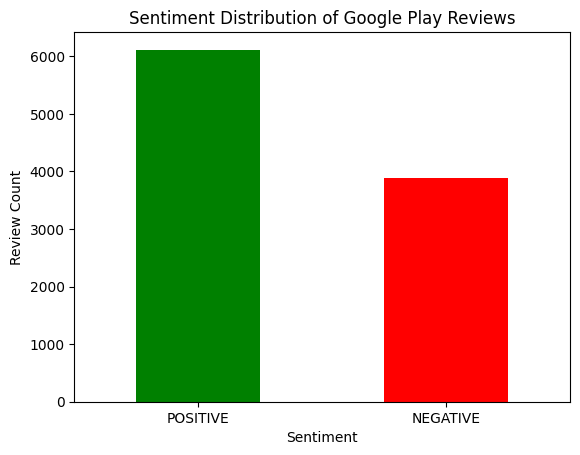

<Figure size 1200x400 with 0 Axes>

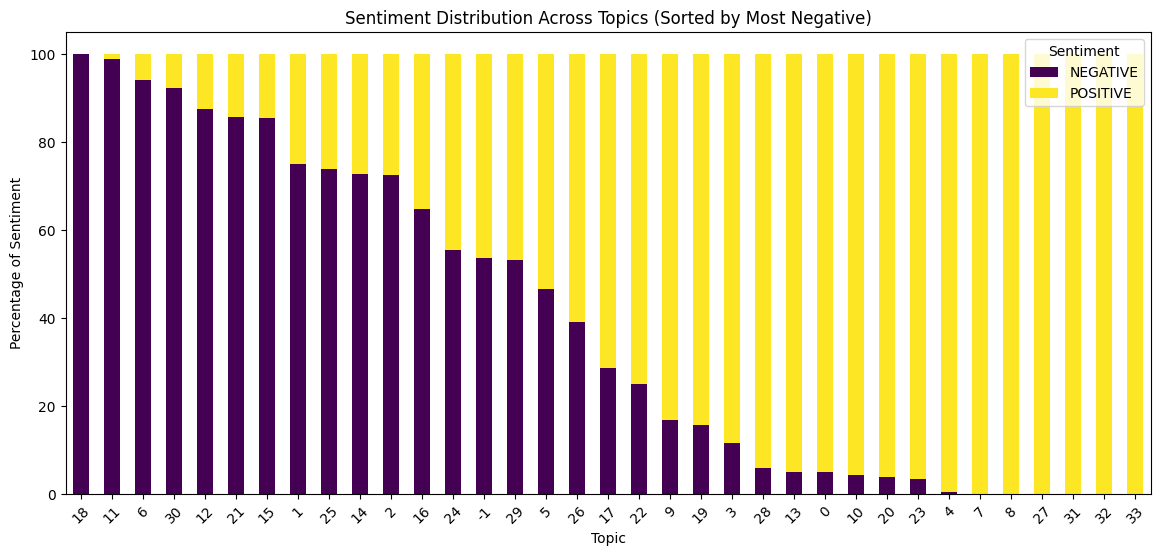

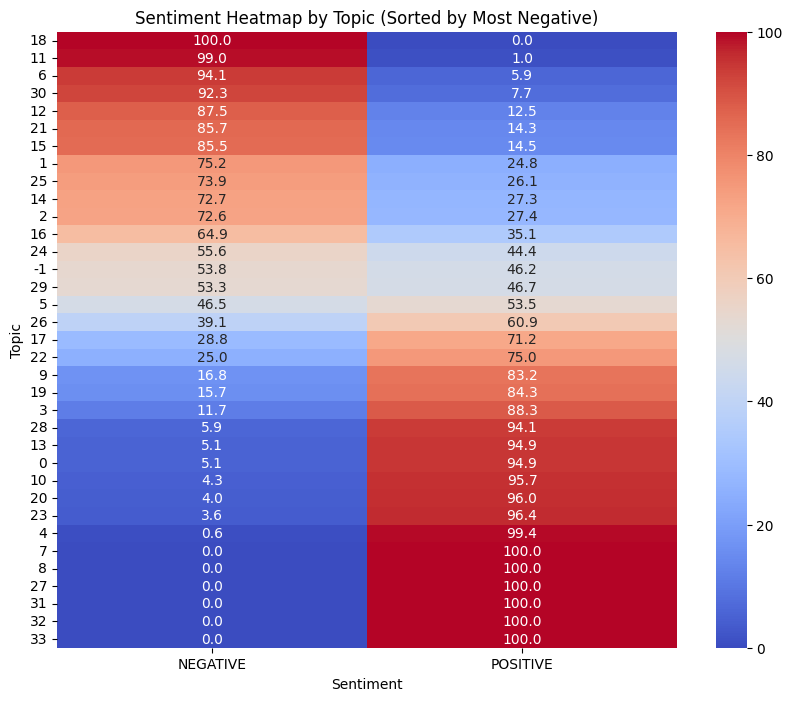

In [ ]:
plot_sentiment_distribution(last_fortress, sentiment_column="sentiment", title="Sentiment Distribution of Google Play Reviews")

plot_sentiment_distribution_by_topic(last_fortress, topic_column="topic", sentiment_column="sentiment")

In [ ]:
# Filter reviews that belong to ad-related topics
last_fortress_ad = filter_ad_related_topics(last_fortress, topic_freq)

# Apply Secondary Topic Modeling on filtered ad-related reviews (with a different topic column)
last_fortress_ad, ad_topic_freq, ad_topic_model = apply_topic_modeling(last_fortress_ad, text_column="content", topic_column="ad_topic")

# Save the new dataset with both the original and ad-related topics
last_fortress_ad.to_csv("/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Ads_Related/last_fortress_ad_reviews.csv", index=False)
ad_topic_freq

2025-03-02 17:55:52,992 - BERTopic - Embedding - Transforming documents to embeddings.



Topics containing ad-related keywords: [2, 24]


Batches:   0%|          | 0/27 [00:00<?, ?it/s]

2025-03-02 17:55:56,204 - BERTopic - Embedding - Completed ✓
2025-03-02 17:55:56,206 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-02 17:55:58,092 - BERTopic - Dimensionality - Completed ✓
2025-03-02 17:55:58,093 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-02 17:55:58,148 - BERTopic - Cluster - Completed ✓
2025-03-02 17:55:58,149 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-02 17:55:58,187 - BERTopic - Representation - Completed ✓
2025-03-02 17:55:58,188 - BERTopic - Topic reduction - Reducing number of topics
2025-03-02 17:55:58,191 - BERTopic - Topic reduction - Reduced number of topics from 14 to 14


,Topic,Count,Name,Representation,Representative_Docs
0,-1,29,-1_game_to_is_it,"[game, to, is, it, the, pc, do, this, my, and]",[I would give this game zero stars if possible...
1,0,27,0_add_adds_the_like,"[add, adds, the, like, games, nothing, game, a...",[The games not the same as the adds but it's c...
2,1,380,1_the_ads_game_is,"[the, ads, game, is, to, and, like, this, ad, it]","[The game isn't like the ads, I redownloaded t..."
3,2,49,2_app_to_and_purchases,"[app, to, and, purchases, of, the, this, it, y...","[Great app, Good app, Not a fun game at all. H..."
4,3,49,3_bugs_buggy_bug_many,"[bugs, buggy, bug, many, but, fix, and, to, so...","[There are so many bugs, and they don't fix it..."
5,4,27,4_glitches_but_game_glitchy,"[glitches, but, game, glitchy, and, to, the, t...",[Lots of glitches. I wish that it was better b...
6,5,14,5_translation_bad_could_it,"[translation, bad, could, it, is, the, we, too...","[I tell u,I wish it did have more rooms on whe..."
7,6,41,6_phone_mobile_game_my,"[phone, mobile, game, my, on, play, it, for, t...",[It's pay to win. The developers provide you w...
8,7,98,7_it_crashing_crashes_game,"[it, crashing, crashes, game, the, to, keeps, ...","[I love this game, but this game has a problem..."
9,8,34,8_it_uninstalled_and_spent,"[it, uninstalled, and, spent, game, to, of, un...",[I am removing this game because it is a pay t...
